In [56]:
import csv
import random
import matplotlib.pyplot as plt

### Arange Numpy

In [ ]:
class array:
    def __init__(self, values):
        self.values = list(values)

    def __add__(self, other):
        if isinstance(other, (int, float)):
            return array([x + other for x in self.values])
        elif isinstance(other, array):
            if len(other.values) != len(self.values):
                raise ValueError("Las dimensiones no coinciden")
            return array([x + y for x, y in zip(self.values, other.values)])
        else:
            return NotImplemented

    def __radd__(self, other):
        return self.__add__(other)

    def __truediv__(self, other):
        if isinstance(other, (int, float)):
            if other == 0:
                raise ZeroDivisionError("División por cero")
            return array([x / other for x in self.values])
        elif isinstance(other, array):
            if len(other.values) != len(self.values):
                raise ValueError("Las dimensiones no coinciden")
            for val in other.values:
                if val == 0:
                    raise ZeroDivisionError("División por cero")
            return array([x / y for x, y in zip(self.values, other.values)])
        else:
            return NotImplemented

    def __rtruediv__(self, other):
        if isinstance(other, (int, float)):
            for val in self.values:
                if val == 0:
                    raise ZeroDivisionError("División por cero")
            return array([other / x for x in self.values])
        else:
            return NotImplemented

    def __repr__(self):
        return f"array({self.values})"
    
    def tolist(self):
        return self.values
    
    def __iter__(self):
        return iter(self.values)
    
    def __len__(self):
        return len(self.values)

def arange(start, stop=None, step=1):
    if stop is None:
        stop = start
        start = 0
    if step == 0:
        raise ValueError("step must not be zero")
    values = []
    current = start
    if step > 0:
        while current < stop:
            values.append(current)
            current += step
    else:
        while current > stop:
            values.append(current)
            current += step
    return array(values)

### 1. Cargar datos desde coin_Bitcoin.csv

In [3]:
def cargar_datos_csv(ruta):
    X, y = [], []
    with open(ruta, newline='', encoding='utf-8') as f:
        lector = csv.DictReader(f)
        for fila in lector:
            # Extraemos las columnas relevantes como números
            X.append([
                float(fila['Open']),
                float(fila['High']),
                float(fila['Low']),
                float(fila['Volume']),
                float(fila['Marketcap']),
            ])
            y.append(float(fila['Close']))
    return X, y

### 2. Autoimplementación Split de Entrenamiento y Prueba

In [4]:
def train_test_split(X, y, test_size=0.2, shuffle=True, random_state=None):
    if random_state is not None:
        random.seed(random_state)
    idxs = list(range(len(X)))
    if shuffle:
        random.shuffle(idxs)
    split = int(len(X) * (1 - test_size))
    train_idx, test_idx = idxs[:split], idxs[split:]
    X_train = [X[i] for i in train_idx]
    y_train = [y[i] for i in train_idx]
    X_test = [X[i] for i in test_idx]
    y_test = [y[i] for i in test_idx]
    return X_train, X_test, y_train, y_test

### 3. DecisionTreeRegressor

In [5]:
class DecisionTreeRegressorNode:
    def __init__(self, depth=0, max_depth=5):
        self.depth = depth
        self.max_depth = max_depth
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.value = None

    def fit(self, X, y):
        if len(set(y)) == 1 or self.depth >= self.max_depth or len(X) < 2:
            self.value = sum(y) / len(y)
            return
        best_var = float('inf')
        best_i, best_t = None, None
        for i in range(len(X[0])):
            values = set(row[i] for row in X)
            for t in values:
                y_left = [y[j] for j in range(len(X)) if X[j][i] <= t]
                y_right = [y[j] for j in range(len(X)) if X[j][i] > t]
                if not y_left or not y_right:
                    continue
                var = (len(y_left) * self.variance(y_left) + len(y_right) * self.variance(y_right)) / len(X)
                if var < best_var:
                    best_var, best_i, best_t = var, i, t
        if best_i is None:
            self.value = sum(y) / len(y)
            return
        self.feature_index = best_i
        self.threshold = best_t
        X_left, y_left, X_right, y_right = [], [], [], []
        for i in range(len(X)):
            if X[i][self.feature_index] <= self.threshold:
                X_left.append(X[i])
                y_left.append(y[i])
            else:
                X_right.append(X[i])
                y_right.append(y[i])
        self.left = DecisionTreeRegressorNode(self.depth+1, self.max_depth)
        self.right = DecisionTreeRegressorNode(self.depth+1, self.max_depth)
        self.left.fit(X_left, y_left)
        self.right.fit(X_right, y_right)

    def predict(self, x):
        if self.value is not None:
            return self.value
        if x[self.feature_index] <= self.threshold:
            return self.left.predict(x)
        else:
            return self.right.predict(x)

    def variance(self, y):
        mean = sum(y)/len(y)
        return sum((val - mean) ** 2 for val in y) / len(y)

### 4. Random Forest Propio

In [6]:
class RandomForestRegressor:
    def __init__(self, n_estimators=10, max_depth=5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = len(X)
        for _ in range(self.n_estimators):
            indices = [random.randint(0, n_samples-1) for _ in range(n_samples)]  # bootstrap
            X_sample = [X[i] for i in indices]
            y_sample = [y[i] for i in indices]
            tree = DecisionTreeRegressorNode(max_depth=self.max_depth)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        preds = []
        for x in X:
            values = [tree.predict(x) for tree in self.trees]
            preds.append(sum(values) / len(values))
        return preds

### 5. Entrenamiento, predicción y evaluación con gráficas

In [7]:
X, y = cargar_datos_csv('coin_Bitcoin.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=10, max_depth=5)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [12]:
# Error cuadrático medio
mse = sum((yt - yp) ** 2 for yt, yp in zip(y_test, y_pred)) / len(y_test)
print(f"Error cuadrático medio en test: {mse:.2f}")

Error cuadrático medio en test: 155524.81


In [8]:
# R^2 score manual
media = sum(y_test) / len(y_test)
ss_tot = sum((yt - media) ** 2 for yt in y_test)
ss_res = sum((yt - yp) ** 2 for yt, yp in zip(y_test, y_pred))
r2 = 1 - (ss_res / ss_tot)
print(f"Coef. de determinación R^2: {r2:.4f}")

Coef. de determinación R^2: 0.9985


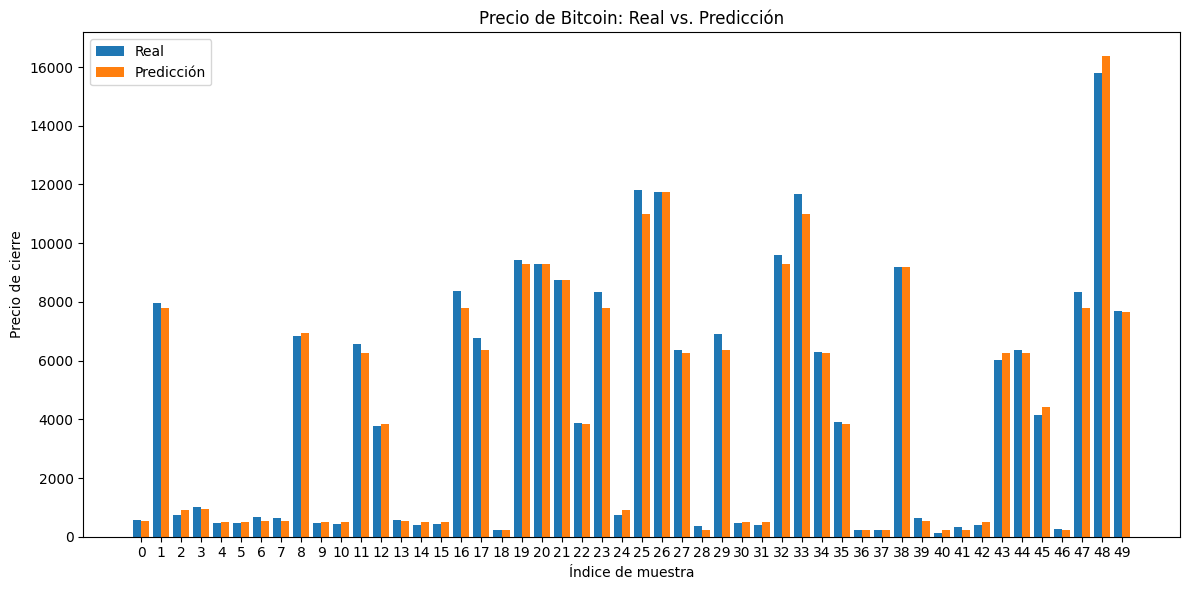

In [72]:
num_samples = 50
indices = arange(num_samples)
bar_width = 0.40

y_test_slice = y_test[:num_samples]
y_pred_slice = y_pred[:num_samples]

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(indices.values, y_test_slice, bar_width, label='Real', color='tab:blue')
rects2 = ax.bar((indices+bar_width).values, y_pred_slice, bar_width, label='Predicción', color='tab:orange')

center_positions = (indices + (indices + bar_width)) / 2

plt.xlabel('Índice de muestra')
plt.ylabel('Precio de cierre')
plt.title('Precio de Bitcoin: Real vs. Predicción')

ax.set_xticks(center_positions.tolist())
ax.set_xticklabels([str(i) for i in indices])
ax.legend()
plt.tight_layout()
plt.show()

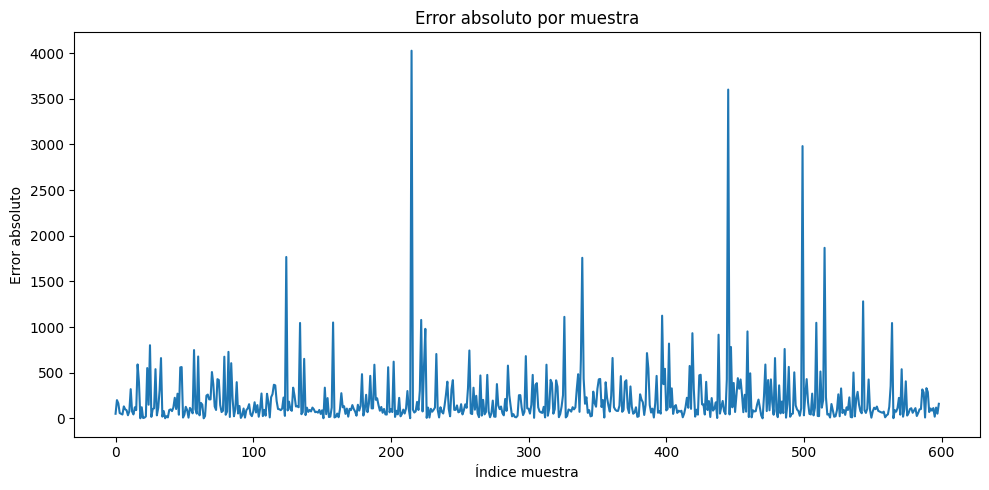

In [14]:
# Errores absolutos
errores = [abs(yt - yp) for yt, yp in zip(y_test, y_pred)]
plt.figure(figsize=(10,5))
plt.plot(errores)
plt.title('Error absoluto por muestra')
plt.xlabel('Índice muestra')
plt.ylabel('Error absoluto')
plt.tight_layout()
plt.show()